In [36]:
import pandapower as pp
import pandapower.networks as pn
from pandapower.plotting import simple_plot

import numpy as np
from mosek.fusion import *
import networkx as nx

In [37]:
# def get_per_unit_impedance(net):

In [38]:
def J_ij(i,j,n):
    # return a single-entry matrix with size n and the (i,j) entry (starting with 0) equal to 1
    J = np.zeros([n,n])
    J[i,j] = 1
    return J

In [39]:
net = pn.case6ww()

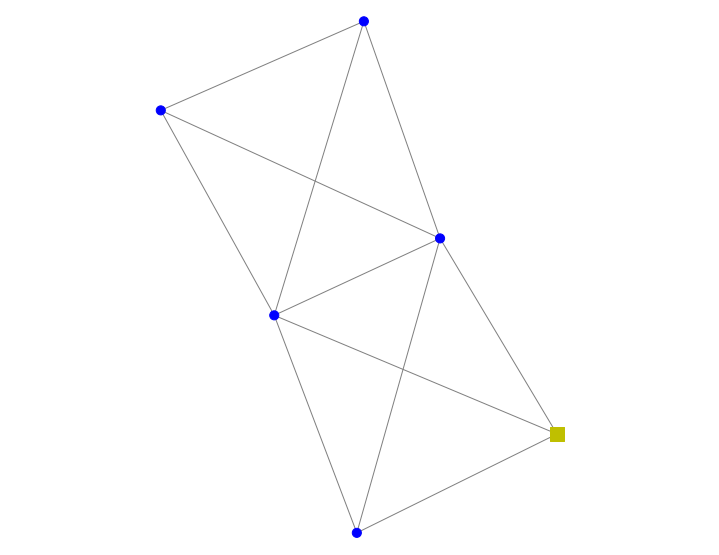

<AxesSubplot:>

In [40]:
simple_plot(net)

In [41]:
# currently the sn_mva (base power) is inconsistent with that in the original MATPOWER cases
net.sn_mva = 100

In [42]:
graph = pp.topology.create_nxgraph(net, multi=False, calc_branch_impedances=True, branch_impedance_unit="ohm")

In [43]:
n = len(net.bus)
n_gen = len(net.gen) + len(net.sgen) + len(net.ext_grid)

In [44]:
M = Model("SDP")
# X = VV*
X = M.variable("X", Domain.inPSDCone(2*n))
# active power generated
p_g = M.variable("p_g", [n, 1])
# reactive power generated
q_g = M.variable("q_g", [n, 1])

In [45]:
# active power constraint will be p_g = p_g_rhs
p_g_rhs_list = [None] * n

# reactive power constraint will be q_g = q_g_rhs
q_g_rhs_list = [None] * n

In [46]:
# fill p_g_rhs_list and q_g_rhs_list; also add the voltage bounds to the problem

for i in range(n):
    bus_row = net.bus.loc[i]
    # "shunt voltage multiplier": X_ii + X_i`i`
    shunt_v_mul = Expr.sum(Expr.mulElm(J_ij(i, i, 2*n) + J_ij(i+n, i+n, 2*n), X))
    # voltage bounds
    M.constraint(shunt_v_mul, Domain.inRange(bus_row["min_vm_pu"]**2, bus_row["max_vm_pu"]**2))

    active_power_list = []  # list of terms in the summation in the active power constraint
    reactive_power_list = []  # list of terms in the summation in the reactive power constraint
    for j in graph.neighbors(i):
        line = graph[i][j]
        G_ij = line["r_ohm"]
        B_ij = line["x_ohm"]
        # "normal voltage multiplier": X_ij + X_i`j`
        normal_v_mul = Expr.sum(Expr.mulElm(X, J_ij(i, j, 2*n) + J_ij(i+n, j+n, 2*n)))
        # "mixed voltage multiplier": X_ij` - X_ji`
        mixed_v_mul = Expr.sum(Expr.mulElm(X, J_ij(i, j+n, 2*n) - J_ij(j, i+n, 2*n)))

        active_power_list.append(Expr.sub(Expr.mul(G_ij, normal_v_mul), Expr.mul(B_ij, mixed_v_mul)))
        reactive_power_list.append(Expr.sub(Expr.neg(Expr.mul(B_ij, normal_v_mul)), \
                                            Expr.mul(G_ij, mixed_v_mul)))

    active_power_sum = Expr.add(active_power_list)  # sum of rhs terms in the active power constraint
    reactive_power_sum = Expr.add(reactive_power_list)  # sum of rhs terms in the reactive power constraint

    # add the shunt term if shunt conductance or susceptance is not 0
    shunt_row = net.shunt.loc[net.shunt["bus"] == i]
    if not shunt_row.empty:
        # TODO: figure out the units
        shunt_g = shunt_row.iloc[0]["p_mw"]  # shunt conductance
        # TODO: shunt susceptance in data seems to be opposite of that in MATPOWER cases
        shunt_b = shun_row.iloc[0]["q_mvar"]  # shunt susceptance
        active_power_sum = Expr.add(Expr.mul(shunt_g, shunt_v_mul), active_power_sum)
        reactive_power_sum = Expr.add(Expr.mul(shunt_b, shunt_v_mul), reactive_power_sum)

    # add real or reactive load if either is not 0
    load_row = net.load.loc[net.load["bus"] == i]
    if not load_row.empty:
        p_d = load_row.iloc[0]["p_mw"]  # real load
        q_d = load_row.iloc[0]["q_mvar"] # reactive load
        active_power_sum = Expr.add(p_d, active_power_sum)
        reactive_power_sum = Expr.add(q_d, reactive_power_sum)
    
    p_g_rhs_list[i] = active_power_sum
    q_g_rhs_list[i] = reactive_power_sum

In [47]:
p_g_rhs = Expr.vstack(p_g_rhs_list)
q_g_rhs = Expr.vstack(q_g_rhs_list)

# active power constraint
M.constraint(Expr.sub(p_g, p_g_rhs), Domain.equalsTo(0))

# reactive power constraint
M.constraint(Expr.sub(q_g, q_g_rhs), Domain.equalsTo(0))

mosek.fusion.LinearConstraint

In [48]:
# power bounds
# FIXME: can simply remove generation variables for non-generator buses (improve performance)?

p_min = np.zeros((n,1))  # vector of active power lower bounds
p_max = np.zeros((n,1))  # vector of active power upper bounds
q_min = np.zeros((n,1))  # vector of reactive power lower bounds
q_max = np.zeros((n,1))  # vector of reactive power upper bounds

for i in range(n):
    # fill the power bounds for generators
    gen_row = None
    if i in net.gen["bus"].array:
        gen_row = net.gen.loc[net.gen["bus"] == i].iloc[0]
    elif i in net.sgen["bus"].array:
        gen_row = net.sgen.loc[net.sgen["bus"] == i].iloc[0]
    elif i in net.ext_grid["bus"].array:
        gen_row = net.ext_grid.loc[net.ext_grid["bus"] == i].iloc[0]
    if gen_row is not None:
        p_min[i] = gen_row["min_p_mw"]
        p_max[i] = gen_row["max_p_mw"]
        q_min[i] = gen_row["min_q_mvar"]
        q_max[i] = gen_row["max_q_mvar"]

        
M.constraint(p_g, Domain.inRange(p_min, p_max))
M.constraint(q_g, Domain.inRange(q_min, q_max))

mosek.fusion.RangedConstraint

In [49]:
# objective function
# TODO
M.objective(ObjectiveSense.Minimize, Expr.sum(p_g))

In [50]:
M.solve()

In [54]:
X_mat = np.reshape(X.level(), [2*n,2*n])

In [52]:
p_g.level()

array([49.99999993, 37.49999994, 44.99999993,  0.        ,  0.        ,
        0.        ])

In [56]:
np.linalg.eig(X_mat)

(array([1.58230928, 1.58230928, 0.88106105, 0.88106105, 0.34630093,
        0.34630093, 0.22848878, 0.22848878, 0.04889463, 0.04889463,
        0.09139237, 0.09139237]),
 array([[-4.24794692e-01,  1.32989554e-01, -3.28061234e-01,
          2.99221674e-01, -1.98160131e-01, -5.88985366e-02,
         -2.97552178e-01, -5.11282334e-02,  5.87951987e-01,
         -1.20823764e-01,  3.41564678e-01, -2.52609947e-01],
        [ 4.72050143e-01, -2.74747651e-02,  4.01471759e-01,
          2.51782450e-02, -1.34970660e-01, -1.81442053e-01,
          1.82007504e-01,  1.62405842e-01,  6.73149946e-01,
         -2.61109918e-02, -1.00336808e-01,  2.31218818e-01],
        [ 4.19097585e-01,  4.03349200e-02, -4.31569974e-01,
          8.01935998e-02,  2.70105722e-01, -1.61204737e-01,
          1.47654523e-01,  4.51742983e-01, -3.74368216e-02,
          1.33106099e-01,  4.56947552e-01, -4.80481048e-01],
        [-3.75294875e-01, -1.15985569e-01, -6.19127251e-02,
          9.19458341e-02,  3.52357545e-01, -5.4